# Setup S3 Buckets

In [1]:
import boto3
import sagemaker
import pandas as pd
from io import StringIO
from pyathena import connect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# List the S3 public bucket content
!aws s3 ls s3://ads508-group7/

                           PRE Arrest/
                           PRE Crime/
                           PRE Foreclosures/
                           PRE LAPD/
                           PRE Unsaved/
                           PRE query-results/
2025-03-15 21:02:43     546709 2023_Registered_Foreclosure_Properties.csv
2025-03-15 21:02:44     552165 2024_Registered_Foreclosure_Properties.csv
2025-03-15 21:40:42   92038326 Arrest_Data_from_2020_to_Present.csv
2025-03-15 21:40:42  255509498 Crime_Data_from_2020_to_Present.csv


In [3]:
# create sagemaker session
sess =  sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

s3 = boto3.client('s3')

In [4]:
# Set S3 Source Location (Public S3 Bucket)
s3_public_path = "s3://ads508-group7"

In [5]:
%store s3_public_path

Stored 's3_public_path' (str)


In [6]:
# Set S3 Destination Location (Private S3 Bucket)
s3_private_path = "s3://{}/ads508-group7".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-817789163072/ads508-group7


In [7]:
%store s3_private_path

Stored 's3_private_path' (str)


In [8]:
#Copy Data From the Public S3 Bucket to our Private S3 Bucket in this Account

In [9]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "2023_Registered_Foreclosure_Properties.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "2024_Registered_Foreclosure_Properties.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "Arrest_Data_from_2020_to_Present.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "Crime_Data_from_2020_to_Present.csv"

copy: s3://ads508-group7/2023_Registered_Foreclosure_Properties.csv to s3://sagemaker-us-east-1-817789163072/ads508-group7/2023_Registered_Foreclosure_Properties.csv
copy: s3://ads508-group7/2024_Registered_Foreclosure_Properties.csv to s3://sagemaker-us-east-1-817789163072/ads508-group7/2024_Registered_Foreclosure_Properties.csv
copy: s3://ads508-group7/Arrest_Data_from_2020_to_Present.csv to s3://sagemaker-us-east-1-817789163072/ads508-group7/Arrest_Data_from_2020_to_Present.csv
copy: s3://ads508-group7/Crime_Data_from_2020_to_Present.csv to s3://sagemaker-us-east-1-817789163072/ads508-group7/Crime_Data_from_2020_to_Present.csv


In [10]:
# List Files in our Private S3 Bucket in this Account
print(s3_private_path)

s3://sagemaker-us-east-1-817789163072/ads508-group7


In [11]:
!aws s3 ls $s3_private_path/

2025-03-27 02:34:10     546709 2023_Registered_Foreclosure_Properties.csv
2025-03-27 02:34:11     552165 2024_Registered_Foreclosure_Properties.csv
2025-03-27 02:34:12   92038326 Arrest_Data_from_2020_to_Present.csv
2025-03-27 02:34:14  255509498 Crime_Data_from_2020_to_Present.csv


In [12]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-{}-{}/ads508-group7/?region={}&tab=overview">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

/tmp/ipykernel_8274/288684959.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [13]:
# store variables for the next notebook
%store

Stored variables and their in-db values:
s3_private_path                         -> 's3://sagemaker-us-east-1-817789163072/ads508-grou
s3_public_path                          -> 's3://ads508-group7'
setup_dependencies_passed               -> True
setup_instance_check_passed             -> True


# EDA

In [14]:
!pip install awswrangler

In [15]:
#import libraries for EDA
import awswrangler as wr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
#create Data quality report function for continous data 

def dqr_cont(df): 
    # Identify continuous features based on numeric data types
    conf = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # Create the report DataFrame
    report = pd.DataFrame({
        'Feature': conf,
        'Count': df[conf].count().values,
        'Missing Values': df[conf].isnull().sum().values,
        'Cardinality': df[conf].nunique().values,
        'Min': df[conf].min().values,
        '1st Quartile': df[conf].quantile(0.25).values,
        'Mean': df[conf].mean().values,
        'Median': df[conf].median().values,
        '3rd Quartile': df[conf].quantile(0.75).values,
        'Max': df[conf].max().values,
        'Standard Deviation': df[conf].std().values,
    }) 
    return report

In [17]:
#create data qualtiy report for categorical data
def dqr_cat(df):
    # Identify categorical features (object dtype)
    catf = df.select_dtypes(include=['object']).columns.tolist()
    
    # Initialize lists to store mode and frequency metrics for each categorical feature
    modes = []
    mode_freqs = []
    second_modes = []
    second_mode_freqs = []
    mode_percentages = []
    second_mode_percentages = []
    
    # Calculate metrics for each categorical feature
    for feature in catf:
        count = df[feature].count()
        # Compute mode and frequency of mode
        mode = df[feature].mode().iloc[0] if count > 0 else None
        mode_freq = df[feature].value_counts().iloc[0] if count > 0 else 0
        
        modes.append(mode)
        mode_freqs.append(mode_freq)
        mode_percentages.append((mode_freq / count) * 100 if count > 0 else 0)
        
        # Calculate second mode and its frequency if it exists
        value_counts = df[feature].value_counts()
        if len(value_counts) > 1:
            second_mode = value_counts.index[1]
            second_mode_freq = value_counts.iloc[1]
        else:
            second_mode = None
            second_mode_freq = 0
        
        second_modes.append(second_mode)
        second_mode_freqs.append(second_mode_freq)
        second_mode_percentages.append((second_mode_freq / count) * 100 if count > 0 else 0)
    
    # Build the quality report DataFrame
    report = pd.DataFrame({
        'Feature': catf,
        'Count': df[catf].count().values,
        'Missing Values': df[catf].isnull().sum().values,
        'Cardinality': df[catf].nunique().values,
        'Mode': modes,
        'Mode Frequency': mode_freqs,
        'Mode %': mode_percentages,
        '2nd Mode': second_modes,
        '2nd Mode Frequency': second_mode_freqs,
        '2nd Mode %': second_mode_percentages,
    })
    
    return report

## Arrest Data

In [18]:
# Read the CSV file directly from S3
### FOR SASHA DF ###
# df_arrest = wr.s3.read_csv("s3://sagemaker-us-east-1-643862913351/ads508-group7/arrests/Arrest_Data_from_2020_to_Present.csv")

### FOR CYNTHIA DF ###
df_arrest = wr.s3.read_csv("s3://ads508-group7/Arrest_Data_from_2020_to_Present.csv")

# Display the first few rows
df_arrest.head()

2025-03-27 02:34:19,208	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1926213632 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.46gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-03-27 02:34:19,369	INFO worker.py:1786 -- Started a local Ray instance.


,Report ID,Report Type,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Disposition Description,Address,Cross Street,LAT,LON,Location,Booking Date,Booking Time,Booking Location,Booking Location Code
0,6636966,BOOKING,07/06/2023 12:00:00 AM,2250.0,8,West LA,817,46,M,B,...,MISDEMEANOR COMPLAINT FILED,900 GAYLEY AV,NaN,34.0637,-118.4482,POINT (-118.4482 34.0637),07/07/2023 12:00:00 AM,143.0,METRO - JAIL DIVISION,4273.0
1,6637119,BOOKING,07/07/2023 12:00:00 AM,1000.0,3,Southwest,396,39,M,B,...,MISDEMEANOR COMPLAINT FILED,40TH PL,VERMONT,34.0100,-118.2915,POINT (-118.2915 34.01),07/07/2023 12:00:00 AM,1156.0,77TH ST,4212.0
2,6624479,BOOKING,06/15/2023 12:00:00 AM,1850.0,7,Wilshire,724,33,F,H,...,MISDEMEANOR COMPLAINT FILED,100 THE GROVE DR,NaN,34.0736,-118.3563,POINT (-118.3563 34.0736),06/15/2023 12:00:00 AM,2251.0,77TH ST,4212.0
3,6636128,BOOKING,07/05/2023 12:00:00 AM,1550.0,2,Rampart,218,30,F,B,...,MISDEMEANOR COMPLAINT FILED,1000 ECHO PARK AV,NaN,34.0741,-118.2590,POINT (-118.259 34.0741),07/05/2023 12:00:00 AM,1940.0,METRO - JAIL DIVISION,4273.0
4,6636650,BOOKING,07/06/2023 12:00:00 AM,1335.0,12,77th Street,1258,31,M,H,...,NaN,7800 S BROADWAY,NaN,33.9689,-118.2783,POINT (-118.2783 33.9689),07/06/2023 12:00:00 AM,1345.0,77TH ST,4212.0


### Basic Data Information

In [19]:
df_arrest.shape

(338332, 25)

In [20]:
#are there duplicates?
df_arrest.duplicated().sum()

0

In [21]:
#get datatypes
df_arrest.dtypes

Report ID                     int64
Report Type                  object
Arrest Date                  object
Time                        float64
Area ID                       int64
Area Name                    object
Reporting District            int64
Age                           int64
Sex Code                     object
Descent Code                 object
Charge Group Code           float64
Charge Group Description     object
Arrest Type Code             object
Charge                       object
Charge Description           object
Disposition Description      object
Address                      object
Cross Street                 object
LAT                         float64
LON                         float64
Location                     object
Booking Date                 object
Booking Time                float64
Booking Location             object
Booking Location Code       float64
dtype: object

In [22]:
#convert date times stamps from object
df_arrest['Arrest Date'] = pd.to_datetime(df_arrest['Arrest Date'], format='%m/%d/%Y %I:%M:%S %p')
df_arrest['Booking Date'] = pd.to_datetime(df_arrest['Booking Date'], format='%m/%d/%Y %I:%M:%S %p')
print(f"Arrest Date dtype: {df_arrest['Arrest Date'].dtype}, Booking Date dtype:{df_arrest['Booking Date'].dtype} ")

Arrest Date dtype: datetime64[ns], Booking Date dtype:datetime64[ns] 


In [23]:
#only include dates from 2023 and 2024, and drop everything else in order to match timeline of the foreclosure data we have
df_a = df_arrest[(df_arrest['Arrest Date'] >= pd.Timestamp('1/01/2023')) &
                (df_arrest['Arrest Date'] < pd.Timestamp('2025-01-01'))]

df_a.shape

(135423, 25)

### Data Quality Report - Continous

In [24]:
pd.options.display.float_format = '{:.2f}'.format
cont_df_a = dqr_cont(df_a)
cont_df_a

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,Report ID,135423,0,135423,3365638.00,6670981.50,67158002.82,6808540.00,230209886.00,252004041.00,101217108.10
1,Time,135414,9,1437,1.00,905.00,1331.17,1400.00,1830.00,2400.00,633.92
2,Area ID,135423,0,21,1.00,3.00,10.09,10.00,15.00,21.00,6.45
3,Reporting District,135423,0,1220,101.00,399.00,1055.38,1065.00,1586.00,2197.00,644.70
4,Age,135423,0,93,0.00,27.00,35.69,34.00,43.00,94.00,12.31
5,Charge Group Code,118396,17027,28,1.00,6.00,13.22,12.00,22.00,29.00,7.61
6,LAT,135423,0,4264,0.00,34.02,34.08,34.06,34.17,34.33,0.36
7,LON,135423,0,4126,-118.67,-118.42,-118.34,-118.31,-118.27,0.00,1.21
8,Booking Time,99826,35597,1437,1.00,542.00,1269.61,1358.00,1931.00,2359.00,737.30
9,Booking Location Code,99826,35597,29,4201.00,4212.00,4252.72,4273.00,4279.00,4283.00,31.33


### Data Quality Report - Categorical

In [25]:
cat_df_a = dqr_cat(df_a)
cat_df_a

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,Report Type,135423,0,2,BOOKING,99826,73.71,RFC,35597,26.29
1,Area Name,135423,0,21,Rampart,13580,10.03,Central,13367,9.87
2,Sex Code,135423,0,2,M,107945,79.71,F,27478,20.29
3,Descent Code,135423,0,16,H,68913,50.89,B,36612,27.04
4,Charge Group Description,118377,17046,27,Miscellaneous Other Violations,17881,15.11,Aggravated Assault,16488,13.93
5,Arrest Type Code,135423,0,7,M,61850,45.67,F,58769,43.40
6,Charge,135423,0,3067,273.5(A)PC,7527,5.56,23152(A)VC,7251,5.35
7,Charge Description,118396,17027,1072,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,7527,6.36,DRUNK DRIVING ALCOHOL/DRUGS,7210,6.09
8,Disposition Description,119864,15559,21,MISDEMEANOR COMPLAINT FILED,69813,58.24,FELONY COMPLAINT FILED,24601,20.52
9,Address,135423,0,25077,2200 W 6TH ST,2221,1.64,600 S ALVARADO ST,1965,1.45


In [26]:
pivot_area = df_a.pivot_table(index=['Area ID', 'Area Name'], values='Report ID', aggfunc='count').reset_index()
pivot_area

,Area ID,Area Name,Report ID
0,1,Central,13367
1,2,Rampart,13580
2,3,Southwest,6979
3,4,Hollenbeck,4372
4,5,Harbor,3720
5,6,Hollywood,7331
6,7,Wilshire,3680
7,8,West LA,3943
8,9,Van Nuys,7095
9,10,West Valley,4196


In [27]:
pivot_charge = df_a.pivot_table(index=['Charge Group Code', 'Charge Group Description'], values='Report ID', aggfunc='count').reset_index()
pivot_charge

,Charge Group Code,Charge Group Description,Report ID
0,1.00,Homicide,624
1,2.00,Rape,489
2,3.00,Robbery,4438
3,4.00,Aggravated Assault,16488
4,5.00,Burglary,2995
5,6.00,Larceny,8065
6,7.00,Vehicle Theft,5182
7,8.00,Other Assaults,11831
8,9.00,Forgery/Counterfeit,267
9,10.00,Fraud/Embezzlement,972


AttributeError: module 'seaborn' has no attribute 'histplot'

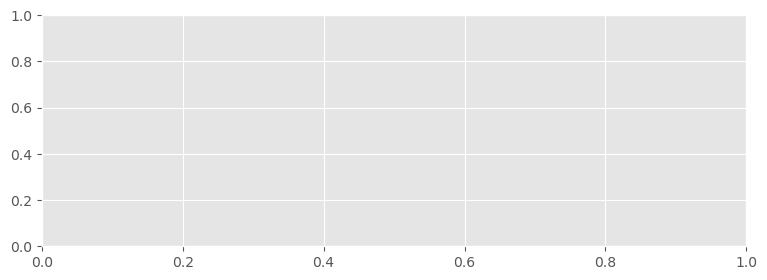

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
sns.histplot(df_a['Area Name'], kde = True)
plt.title('Distribution of Arrests by Station')
plt.xticks(rotation=90) 
plt.show()

## Crime Data

In [ ]:
# Read the CSV file directly from S3
### FOR SASHA DF ###
# df_crime = wr.s3.read_csv("s3://sagemaker-us-east-1-643862913351/ads508-group7/Crime_Data_from_2020_to_Present.csv")

### FOR CYNTHIA DF ###
df_crime = wr.s3.read_csv("s3://ads508-group7/Crime_Data_from_2020_to_Present.csv")

# Display the first few rows
df_crime.head()

In [ ]:
df_crime.shape

In [ ]:
#are there duplicates?
df_crime.duplicated().sum()

In [ ]:
df_crime.dtypes

In [ ]:
# Convert date time stamps from object to datetime
df_crime['DATE OCC'] = pd.to_datetime(df_crime['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')

# will drop Date Rptd, and just use DATE OCC for the rest of the project
df_cr = df_crime.drop('Date Rptd', axis=1)

# Check the new dataframe shape and top rows
print(df_cr.shape)
print(df_cr.head())


In [ ]:
#only include dates from 2023 and 2024, and drop everything else in order to match timeline of the foreclosure data we have
df_cr = df_cr[(df_cr['DATE OCC'] >= pd.Timestamp('1/01/2023')) &
                (df_cr['DATE OCC'] < pd.Timestamp('2025-01-01'))]

df_cr.shape

In [ ]:
df_cr.head()

### Data Quality Reports

In [ ]:
#dqr continous
pd.options.display.float_format = '{:.2f}'.format
cont_df_cr = dqr_cont(df_cr)
cont_df_cr

In [ ]:
#dqr categorical
cat_df_cr = dqr_cat(df_cr)
cat_df_cr

## Foreclosure Data

In [ ]:
# Read the CSV file directly from S3 2023 data

### SASHA DF ###
# df_fc2023 = wr.s3.read_csv("s3://sagemaker-us-east-1-643862913351/ads508-group7/2023_Registered_Foreclosure_Properties.csv")

### CYNTHIA DF ###
df_fc2023 = wr.s3.read_csv("s3://ads508-group7/2023_Registered_Foreclosure_Properties.csv")

# Display the first few rows
df_fc2023.head()

In [ ]:
df_fc2023.shape

In [ ]:
#are there duplicates?
df_fc2023.duplicated().sum()

In [ ]:
df_fc2023.dtypes

In [ ]:
#dqr contin, 2023
pd.options.display.float_format = '{:.2f}'.format
cont_df_23 = dqr_cont(df_fc2023)
cont_df_23

In [ ]:
#dqr categorical 2023
cat_df_23 = dqr_cat(df_fc2023)
cat_df_23

In [ ]:
# Read the CSV file directly from S3, 2024 data
### SASHA DF ###
#df_fc2024 = wr.s3.read_csv("s3://sagemaker-us-east-1-643862913351/ads508-group7/2024_Registered_Foreclosure_Properties.csv")

### CYNTHIA DF ###
df_fc2024 = wr.s3.read_csv("s3://ads508-group7/2024_Registered_Foreclosure_Properties.csv")

# Display the first few rows
df_fc2024.head()

In [ ]:
df_fc2024.shape

In [ ]:
#are there duplicates?
df_fc2024.duplicated().sum()

In [ ]:
df_fc2024.dtypes

In [ ]:
#dqr contin, 2024
pd.options.display.float_format = '{:.2f}'.format
cont_df_24 = dqr_cont(df_fc2024)
cont_df_24

In [ ]:
#dqr categorical 2024
cat_df_24 = dqr_cat(df_fc2024)
cat_df_24

# Feature Engineering

## Transformations on Crime DF

In [ ]:
# drop any other variables we've deemed irrelevant for our project
df_cr_mod = df_cr.drop(
    ['TIME OCC', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 
                 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'Weapon Used Cd',	'Weapon Desc', 'LAT', 'LON'], axis=1)

In [ ]:
df_cr_mod.head()

In [ ]:
# we then want to aggregate the df into a rolled up count of incidents by date and LAPD station ID
df_crime_agg = df_cr_mod.groupby(['DATE OCC', 'AREA']).size().reset_index(name='Total Crimes')

# Rename columns to match format
df_crime_agg.rename(columns={'DATE OCC': 'Date Occurred', 'AREA': 'Area ID'}, inplace=True)
print(df_crime_agg.head())

## Transformations on Arrest DF

In [ ]:
# drop any other variables we've deemed irrelevant for our project
df_a_mod = df_a.drop(
    ['Report Type', 'Time', 'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code', 'Charge Group Code', 'Charge Group Description', 
     'Arrest Type Code', 'Charge', 'Charge Description', 'Disposition Description', 'Address', 'Cross Street', 'Location', 'Booking Date', 'Booking Time',
     'Booking Location', 'Booking Location Code', 'LAT', 'LON'], axis=1)

In [ ]:
df_a_mod.head()

In [ ]:
# we then want to aggregate the df into a rolled up count of incidents by date and LAPD station ID
df_arrest_agg = df_a_mod.groupby(['Arrest Date', 'Area ID']).size().reset_index(name='Total Arrests')

# Rename columns to match the desired format
df_arrest_agg.rename(columns={'Arrest Date': 'Arrest Date', 'Area ID': 'Area ID'}, inplace=True)

# Display the first few rows
print(df_arrest_agg.head())

## Transformations on Foreclosure DFs

In [ ]:
# Foreclosure 2023
# drop any variables we've deemed irrelevant for our project
df_fc2023_mod = df_fc2023.drop(
    ['Property Address', 'Property City', 'Property State', 'Council District', 'Lender', 'Lender Contact', 'Lender Contact Phone', 'Property Management', 
     'Property Management Contact',	'Property Management Address', 'Property Management Contact Phone', 'Property on map', 'lon', 'lat', 'Property Type'], axis=1)

In [ ]:
df_fc2023_mod.head()

In [ ]:
# Foreclosure 2024
# drop any variables we've deemed irrelevant for our project
df_fc2024_mod = df_fc2024.drop(
    ['PropertyAddress',	'PropertyCity',	'PropertyState', 'CouncilDistrict',	'Lender', 'LenderContact', 'LenderContactPhone', 'PropertyManagement', 
     'PropertyManagementContact', 'PropertyManagementAddress', 'PropertyMgmtContactPhone', 'Property map', 'lon', 'lat', 'Property Type'], axis=1)

In [ ]:
df_fc2024_mod.head()

In [ ]:
df_fc2023_mod.dtypes

In [ ]:
df_fc2024_mod.dtypes

In [ ]:
# Convert Property Zip from int64 to string to avoid losing any leading 0
df_fc2023_mod['Property Zip'] = df_fc2023_mod['Property Zip'].astype(str)
df_fc2024_mod['PropertyZip'] = df_fc2024_mod['PropertyZip'].astype(str)

In [ ]:
# Rename the column to 'Property Zip' for uniformity
df_fc2024_mod = df_fc2024_mod.rename(columns={'PropertyZip': 'Property Zip'})

In [ ]:
# revise 2024 and 2023 Registered Date format to match

# Convert the "Registered Date" in df_fc2024_mod to datetime
df_fc2024_mod['Registered Date'] = pd.to_datetime(df_fc2024_mod['Registered Date'], errors='coerce')

# Convert the "Registered Date" in df_fc2023_mod to datetime
df_fc2023_mod['Registered Date'] = pd.to_datetime(df_fc2023_mod['Registered Date'], format='%m/%d/%Y', errors='coerce')

In [ ]:
# Verify that both DataFrames now have the correct datetime format
print(df_fc2024_mod['Registered Date'].head())
print(df_fc2023_mod['Registered Date'].head())

In [ ]:
print(df_fc2023_mod.shape)

In [ ]:
print(df_fc2024_mod.shape)

In [ ]:
# combine the two Foreclosure DataFrames
df_fc_combined = pd.concat([df_fc2023_mod, df_fc2024_mod], ignore_index=True)

In [ ]:
# Verify the combined DataFrame
print(df_fc_combined.shape)
print(df_fc_combined.head(10))

In [ ]:
# we are seeing duplicates in the APN (Assessor's Parcel Number, so we want to investigate further
unique_apn_count = df_fc_combined['APN'].nunique()
print("Number of unique APN values:", unique_apn_count)

# Sort the dataframe by APN and Foreclosure Date
df_fc_combined_sorted = df_fc_combined.sort_values(by=['APN', 'Registered Date'])

# Find duplicates based on APN
duplicates_sorted = df_fc_combined_sorted[df_fc_combined_sorted.duplicated(subset=['APN'], keep=False)]

# Display the sorted duplicates
duplicates_sorted.head(20)

In [ ]:
# it seems unlikely the same house would be foreclosed on more than one in a two year span and perhaps is how LA tracks the foreclosure process
# we will drop duplicate APNs and only keep the oldest Registered Date

# Sort the dataframe by APN and Registered Date (oldest date first)
df_fc_combined_sorted = df_fc_combined.sort_values(by=['APN', 'Registered Date'])

# Remove duplicates based on APN, keeping the first (oldest) row
df_fc_combined_no_duplicates = df_fc_combined_sorted.drop_duplicates(subset=['APN'], keep='first')

# Display the result
unique_apn_count = df_fc_combined_no_duplicates['APN'].nunique()
print("Number of unique APN values:", unique_apn_count)
print(df_fc_combined_no_duplicates.shape)
df_fc_combined_no_duplicates.head(10)

In [ ]:
# next we have LAPD data on zip codes and what Area ID they correspond to, so we will combine that information

bucket_name = 'ads508-group7'
file_key = 'LAPD/LAPD Area ID.csv' 

# Download the file from S3 to a pandas DataFrame
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df_lapd = pd.read_csv(obj['Body'])

# Display the first few rows 
print(df_lapd.head())

In [ ]:
# Ensure they are in string format using .loc to avoid SettingWithCopyWarning
df_fc_combined_no_duplicates.loc[:, 'Property Zip'] = df_fc_combined_no_duplicates['Property Zip'].astype(str)
df_lapd.loc[:, 'Zip'] = df_lapd['Zip'].astype(str)

# Merge the dataframes
df_fc_lapd = pd.merge(df_fc_combined_no_duplicates, df_lapd[['Area ID', 'Zip']], left_on='Property Zip', right_on='Zip', how='left')

# Rename columns to match the desired output format
df_fc_lapd = df_fc_lapd.rename(columns={'Registered Date': 'Foreclosure Date', 'Property Zip': 'Zip Code'})

# Display the first few rows
print(df_fc_lapd.head(20))

In [ ]:
# Count the number of NaN values in the 'Area ID' column
nan_count_areaID = df_fc_lapd['Area ID'].isna().sum()

print(f"Number of NaN values in 'Area ID': {nan_count_areaID}")

In [ ]:
########### STOPPED HERE TO FIX ABOVE ISSUE --- WILL CONTINUE WORK ON 3/25 -CP ##############

# Drop the "Zip" column
df_fc_lapd = df_fc_lapd.drop(columns=['Zip'])

# Fill NaN values with a placeholder, 0
df_fc_lapd['Area ID'] = df_fc_lapd['Area ID'].fillna(0).astype(int)

# Convert Area ID column to integers
df_fc_lapd['Area ID'] = df_fc_lapd['Area ID'].astype(int)
print(df_fc_lapd.head(30))

## Upload transformed dataframes into S3

In [ ]:
# Upload Arrest df
# Define S3 bucket and folder
bucket = "ads508-group7"
folder = "Arrest"
file_name = "df_arrest_aggregate.csv"

# Convert DataFrame to CSV in-memory
csv_buffer = StringIO()
df_arrest_agg.to_csv(csv_buffer, index=False)

# Upload to S3 using existing boto3 session
s3_client = boto3.client("s3")
s3_client.put_object(
    Bucket=bucket,
    Key=f"{folder}/{file_name}",
    Body=csv_buffer.getvalue()
)

print(f"Uploaded to: s3://{bucket}/{folder}/{file_name}")

In [ ]:
# Upload Crime df
# Define S3 bucket and folder
bucket = "ads508-group7"
folder = "Crime"
file_name = "df_crime_aggregate.csv"

# Convert DataFrame to CSV in-memory
csv_buffer = StringIO()
df_crime_agg.to_csv(csv_buffer, index=False)

# Upload to S3 using existing boto3 session
s3_client = boto3.client("s3")
s3_client.put_object(
    Bucket=bucket,
    Key=f"{folder}/{file_name}",
    Body=csv_buffer.getvalue()
)

print(f"Uploaded to: s3://{bucket}/{folder}/{file_name}")

In [ ]:
# Upload foreclosure df
# Define S3 bucket and folder
bucket = "ads508-group7"
folder = "Foreclosures"
file_name = "df_fc_combined_transformed.csv"

# Convert DataFrame to CSV in-memory
csv_buffer = StringIO()
df_fc_combined.to_csv(csv_buffer, index=False)

# Upload to S3 using existing boto3 session
s3_client = boto3.client("s3")
s3_client.put_object(
    Bucket=bucket,
    Key=f"{folder}/{file_name}",
    Body=csv_buffer.getvalue()
)

print(f"✅ Uploaded to: s3://{bucket}/{folder}/{file_name}")

# Visualizations

In [ ]:
# view overlay of Arrests and Crimes by quarter and year

# Create 'Year_Quarter' for df_a_mod (Arrest Date)
if 'Year_Quarter' not in df_a_mod.columns:
    df_a_mod['Year_Quarter'] = pd.to_datetime(df_a_mod['Arrest Date']).dt.to_period('Q').astype(str)

# Create 'Year_Quarter' for df_cr_mod (DATE OCC)
if 'Year_Quarter' not in df_cr_mod.columns:
    df_cr_mod['Year_Quarter'] = pd.to_datetime(df_cr_mod['DATE OCC']).dt.to_period('Q').astype(str)

# Count the occurrences of each quarter for both datasets
arrest_counts = df_a_mod['Year_Quarter'].value_counts().sort_index()
crime_counts = df_cr_mod['Year_Quarter'].value_counts().sort_index()

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Quarter': arrest_counts.index,
    'Arrests': arrest_counts.values,
    'Crimes': crime_counts.reindex(arrest_counts.index, fill_value=0).values  # align indices, fill missing with 0
})

# Plot the data with overlapping bars
plt.figure(figsize=(12, 6))

# Plot Crimes bars
plt.bar(data['Quarter'], data['Crimes'], color='orange', label='Crimes', edgecolor='black')

# Plot Arrests bars on top of Crimes bars
plt.bar(data['Quarter'], data['Arrests'], color='purple', label='Arrests', edgecolor='black')

# Add titles and labels
plt.title("Overlay of Arrests and Crimes by Quarter and Year", fontsize=16)
plt.xlabel('Quarter and Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.legend(title='Legend', fontsize=12)

# Show the plot
plt.show()

In [ ]:
# view correlation matrix between crime, arrest and foreclosure counts

# Ensure 'Year_Quarter' in df_a_mod is a string
df_a_mod['Year_Quarter'] = df_a_mod['Arrest Date'].dt.to_period('Q').astype(str)

# Group by 'Year_Quarter'
# For Arrest count 
arrest_counts = df_a_mod.groupby('Year_Quarter').size().reset_index(name='Arrest_Count')

# For Crime Count
crime_counts = df_cr_mod.groupby('Year_Quarter').size().reset_index(name='Crime_Count')

# For Foreclosure Count
foreclosure_counts = df_fc_combined.groupby('Year_Quarter').size().reset_index(name='Foreclosure_Count')

# Now, merge the three datasets: crime, arrest, and foreclosure counts
df_corr_combined = pd.merge(crime_counts, arrest_counts, on='Year_Quarter', how='inner')
df_corr_combined = pd.merge(df_corr_combined, foreclosure_counts, on='Year_Quarter', how='inner')

# Debugging: Check the columns of df_corr_combined to verify there are no duplicate columns
print("Columns after merge:")
print(df_corr_combined.columns)

# Calculate the correlation matrix for crime, arrest, and foreclosure counts
corr_matrix = df_corr_combined[['Crime_Count', 'Arrest_Count', 'Foreclosure_Count']].corr()

# Mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Visualize the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title("Correlation Matrix between Crime, Arrests, and Foreclosures")
plt.show()

# Setup Athena Database

## Create Database

In [32]:
# Importing the necessary libraries to create Athena database
import boto3
import sagemaker
from pyathena import connect
import pandas as pd

# Configuration of the athena |
region = boto3.Session().region_name
group_bucket = "ads508-group7"
database_name = "crime_foreclosure_db"
s3_staging_dir = f"s3://{group_bucket}/query-results/"
output_location = f"s3://{group_bucket}/final-joined/team7/"

# Connecting to athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cursor = conn.cursor()

# creation of the database
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")
print(f"Database '{database_name}' created or already exists.")

Database 'crime_foreclosure_db' created or already exists.


## Create tables in Athena

### The Arrests table



In [33]:
cursor.execute("DROP TABLE IF EXISTS crime_foreclosure_db.arrests_agg")

cursor.execute("""
CREATE EXTERNAL TABLE crime_foreclosure_db.arrests_agg (
    date string,
    area int,
    total_arrests int
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
    'separatorChar' = ',',
    'quoteChar'     = '"',
    'serialization.null.format' = ''
)
LOCATION 's3://ads508-group7/Arrest/'
TBLPROPERTIES ('skip.header.line.count'='1')
""")
print("created 'arrests_agg' .")


created 'arrests_agg' .


### The Foreclosure table

In [41]:
cursor.execute("DROP TABLE IF EXISTS crime_foreclosure_db.foreclosures_agg")

cursor.execute("""
CREATE EXTERNAL TABLE crime_foreclosure_db.foreclosures_agg (
    date string,
    area int,
    total_foreclosures int
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
    'separatorChar' = ',',
    'quoteChar'     = '"',
    'serialization.null.format' = ''
)
LOCATION 's3://ads508-group7/Foreclosures/'
TBLPROPERTIES ('skip.header.line.count'='1')
""")
print("Table 'foreclosures_agg' created")

SyntaxError: invalid syntax (848283867.py, line 1)

### The Crime table

In [35]:
# Crime Table
cursor.execute("DROP TABLE IF EXISTS crime_foreclosure_db.crime_agg")

cursor.execute("""
CREATE EXTERNAL TABLE crime_foreclosure_db.crime_agg (
    date string,
    area int,
    total_crimes int
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
    'separatorChar' = ',',
    'quoteChar'     = '"',
    'serialization.null.format' = ''
)
LOCATION 's3://ads508-group7/Crime/'
TBLPROPERTIES ('skip.header.line.count'='1')
""")
print("Table 'crime_agg' created.")

Table 'crime_agg' created.


## Validating the setup

In [36]:
# List of tables to validate
agg_tables = ["arrests_agg", "crime_agg", "foreclosures_clean"]

# Step 1: Checking to make sure the tables were created
existing_tables = pd.read_sql("SHOW TABLES IN crime_foreclosure_db", conn)
print(" Tables in 'crime_foreclosure_db':")
display(existing_tables)

# Step 2: Preview first 5 rows of each table
for table in agg_tables:
    print(f"\n Preview of '{table}':")
    try:
        preview_df = pd.read_sql(f"SELECT * FROM crime_foreclosure_db.{table} LIMIT 5", conn)
        display(preview_df)
    except Exception as e:
        print(f" Error loading {table}: {e}")


/tmp/ipykernel_8274/2720230717.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  existing_tables = pd.read_sql("SHOW TABLES IN crime_foreclosure_db", conn)


 Tables in 'crime_foreclosure_db':


,tab_name
0,arrests_agg
1,crime_agg
2,foreclosures_agg
3,foreclosures_clean



 Preview of 'arrests_agg':


/tmp/ipykernel_8274/2720230717.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preview_df = pd.read_sql(f"SELECT * FROM crime_foreclosure_db.{table} LIMIT 5", conn)


,date,area,total_arrests
0,2023-01-01,1,10
1,2023-01-01,2,4
2,2023-01-01,3,9
3,2023-01-01,4,7
4,2023-01-01,5,5



 Preview of 'crime_agg':


/tmp/ipykernel_8274/2720230717.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preview_df = pd.read_sql(f"SELECT * FROM crime_foreclosure_db.{table} LIMIT 5", conn)


,date,area,total_crimes
0,2023-01-01,1,68
1,2023-01-01,2,49
2,2023-01-01,3,67
3,2023-01-01,4,50
4,2023-01-01,5,48



 Preview of 'foreclosures_clean':


/tmp/ipykernel_8274/2720230717.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preview_df = pd.read_sql(f"SELECT * FROM crime_foreclosure_db.{table} LIMIT 5", conn)


,foreclosure_date,area id,foreclosure_count
0,2023-01-01,9,1
1,2023-01-01,17,1
2,2023-01-01,18,1
3,2023-01-02,3,2
4,2023-01-02,6,2


## Creating the final table by JOIN

In [65]:
# Query to join the aggregate tables into one
query = """
SELECT 
    a.date,
    a.area,
    a.total_arrests,
    c.total_crimes,
    f.total_foreclosures
FROM crime_foreclosure_db.arrests_agg a
JOIN crime_foreclosure_db.crime_agg c 
    ON a.date = c.date AND a.area = c.area
JOIN crime_foreclosure_db.foreclosures_agg f 
    ON a.date = f.date AND a.area = f.area
"""

# loading the query into a dataframe
combined_agg = pd.read_sql(query, conn)

# Preview the result
print(Combined_agg.head())

/tmp/ipykernel_8274/3661753512.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  combined_agg = pd.read_sql(query, conn)


         date  area  total_arrests  total_crimes  total_foreclosures
0  2023-01-01     9              8            45                   1
1  2023-01-01    17              5            61                   1
2  2023-01-01    18             12           102                   1
3  2023-01-02     3              5            42                   2
4  2023-01-02     6              5            33                   2


## Setting up the Regression

### Train and test set

In [66]:
len(combined_agg)

2009

In [69]:
from sklearn.model_selection import train_test_split

#split all data into 90% train and 10% holdout
combined_train, combined_holdout = train_test_split(
    combined_agg,
    test_size=.10,
    )

# Split holdout data into 50% validation and 50% test
combined_validation, combined_test = train_test_split(
        combined_holdout,
        test_size=.50,
)



### Validate the split

In [70]:
# Total row count
total = len(combined_train) + len(combined_test) + len(combined_validation)

# Check percentages
print(f"Train size: {len(combined_train)} rows ({len(combined_train)/total:.1%})")
print(f"Validation size: {len(combined_validation)} rows ({len(combined_validation)/total:.1%})")
print(f"Test size: {len(combined_test)} rows ({len(combined_test)/total:.1%})")
print(f"Total rows: {total}")

Train size: 1808 rows (90.0%)
Validation size: 100 rows (5.0%)
Test size: 101 rows (5.0%)
Total rows: 2009
